# Chapter 2: Water Influx Models
**Author:** Ade Anggi Naluriawan Santoso
### Based on "Advanced Reservoir Engineering" by Tarek Ahmed & Paul D. McKinney

**Objective:**
This notebook covers the mathematical modeling of water encroachment into a reservoir. We will implement three distinct methods to calculate cumulative water influx ($W_e$) based on reservoir pressure history:

1.  **Van Everdingen-Hurst (VEH):** The rigorous analytical solution using the diffusivity equation and superposition.
2.  **Carter-Tracy:** An approximate method that eliminates the need for full superposition (computationally faster).
3.  **Fetkovich:** A simplified approach assuming pseudo-steady state flow from a finite aquifer.

**Key Challenges:**
* Handling the time-dependent boundary pressure ($P_{wf}$ or reservoir pressure).
* Calculating the dimensionless Water Influx function ($Q_D$).
* Comparing infinite vs. finite aquifer behaviors.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Aquifer Properties & Geometry

Before modeling, we must define the aquifer's physical characteristics. The "strength" of an aquifer is often summarized by the **Aquifer Constant ($U$)**.

**Aquifer Constant ($U$):**
$$U = 1.119 \phi c_t h r_w^2 \left( \frac{\theta}{360} \right)$$

* $\theta$: Encroachment angle (360° for full radial, 180° for fault bounded).
* $c_t$: Total compressibility of the aquifer ($c_w + c_f$).

**Dimensionless Time ($t_D$):**
$$t_D = \frac{0.006328 k t}{\phi \mu_w c_t r_w^2}$$

In [2]:
class AquiferProps:
    def __init__(self, pi, phi, mu_w, ct, k, h, rw, ra=None, theta=360):
        """
        Initialize Aquifer Properties.
        
        Args:
            pi (float): Initial reservoir/aquifer pressure (psi)
            phi (float): Aquifer porosity (fraction)
            mu_w (float): Water viscosity (cp)
            ct (float): Total aquifer compressibility (1/psi)
            k (float): Aquifer permeability (md)
            h (float): Aquifer thickness (ft)
            rw (float): Reservoir radius (ft)
            ra (float): Aquifer outer radius (ft). If None, assumes Infinite.
            theta (float): Encroachment angle (degrees). Default 360.
        """
        self.pi = pi
        self.phi = phi
        self.mu_w = mu_w
        self.ct = ct
        self.k = k
        self.h = h
        self.rw = rw
        self.ra = ra
        self.theta = theta
        
        # Calculate Aquifer Constant U (bbl/psi)
        # U = 1.119 * phi * ct * h * rw^2 * (theta/360)
        self.U = 1.119 * phi * ct * h * (rw**2) * (theta / 360.0)
        
        # Calculate tD multiplier constant
        # tD = (constant * t)
        self.tD_const = (0.006328 * k) / (phi * mu_w * ct * (rw**2))

    def get_tD(self, t_days):
        """Convert time in days to dimensionless time tD"""
        return self.tD_const * t_days

    def __str__(self):
        geometry = "Infinite" if self.ra is None else f"Finite (ra={self.ra} ft)"
        return (f"Aquifer Properties:\n"
                f"  Type: {geometry}\n"
                f"  Aquifer Constant (U): {self.U:.4f} bbl/psi\n"
                f"  Permeability: {self.k} md\n"
                f"  Initial Pressure: {self.pi} psi")

# Example Initialization (Infinite Radial Aquifer)
aquifer = AquiferProps(
    pi=2500, phi=0.20, mu_w=0.5, ct=6e-6, 
    k=50, h=30, rw=1000, ra=None, theta=360
)
print(aquifer)

Aquifer Properties:
  Type: Infinite
  Aquifer Constant (U): 40.2840 bbl/psi
  Permeability: 50 md
  Initial Pressure: 2500 psi


## 2a. Van Everdingen-Hurst (VEH) Model

The VEH method is an exact solution to the diffusivity equation. It calculates water influx ($W_e$) using the **Principle of Superposition** to account for the changing boundary pressure.

$$W_e(t) = U \sum_{j=0}^{n-1} \Delta P_j \cdot Q_D(t_D - t_{Dj})$$

Where:
* $\Delta P_j$: The pressure drop step at time step $j$.
* $Q_D(t_D)$: The dimensionless cumulative water influx function.

**Calculating $Q_D(t_D)$:**
For an **Infinite Radial Aquifer**, $Q_D$ is usually calculated using polynomial approximations (like those by Klins, Edwardson, etc.) to avoid solving Bessel functions iteratively.

*Below, we implement the Edwardson et al. approximation for Infinite Radial Systems.*

In [3]:
def calculate_QD_infinite(tD):
    """
    Calculates Dimensionless Influx QD for Infinite Radial Aquifer.
    Approximation by Edwardson et al. (Standard Industry Approx).
    """
    # Handle scalar or array input
    tD = np.atleast_1d(tD)
    QD = np.zeros_like(tD)
    
    # Region 1: tD < 0.01
    mask1 = tD < 0.01
    # Simple approx: 2 * sqrt(tD / pi)
    QD[mask1] = 2.0 * np.sqrt(tD[mask1] / np.pi)
    
    # Region 2: 0.01 <= tD < 200 (Polynomial Approx)
    mask2 = (tD >= 0.01) & (tD < 200)
    t = tD[mask2]
    sqrt_t = np.sqrt(t)
    # Coefficients for polynomial
    num = (1.129557 + 1.160436*sqrt_t + 0.264382*t + 0.011303*t*sqrt_t)
    den = (1.0 + 0.663245*sqrt_t + 0.059539*t + 0.000707*t*sqrt_t)
    QD[mask2] = (num / den) * sqrt_t
    
    # Region 3: tD >= 200
    mask3 = tD >= 200
    # Approximation: (-4.29881 + 2.02566 * tD) / ln(tD) ... 
    # Or simpler: (2 * tD) / (ln(tD) - 0.5) is a common one, 
    # but let's use the Klins/Edwardson high tD approx:
    t = tD[mask3]
    QD[mask3] = (2 * t - 1.384) / (np.log(t) + 0.80907) 
    # Note: There are various correlations; this one is robust for high tD.
    
    return QD

def calculate_We_VEH(time_days, pressure_history, aq: AquiferProps):
    """
    Calculates Cumulative Water Influx (We) using VEH Superposition.
    
    time_days: Array of time steps (days)
    pressure_history: Array of reservoir pressures at boundary (psi)
    aq: AquiferProps object
    """
    We = np.zeros_like(time_days)
    
    # 1. Calculate Pressure Drops (Delta P)
    # The superposition assumes step changes. 
    # DP_0 = Pi - P_1
    # DP_1 = P_1 - P_2 ...
    # However, strict VEH uses: DP_j = (P_{j-1} - P_{j+1}) / 2 usually for linear interpolation,
    # or simple steps: DP_j = Pi - P_j (Total Drawdown) which is wrong for superposition.
    # Correct Superposition Step: The pressure drop imposed at time j is (P_{j-1} - P_j).
    
    # Let's normalize to the "Plateau" method (Ahmed Book p. 645 approx):
    # Delta P_j = (P_{j-2} - P_j) / 2 is often used for discrete intervals.
    # Let's use the standard Finite Difference form:
    # DP_0 = Pi - P_0 (At t=0)
    # DP_1 = P_0 - P_1 (At t=1) ...
    
    # Constructing the Delta P array
    # First drop is Pi - P_at_t0 (usually 0 if P starts at Pi)
    # We assume P_history[0] is at t=0.
    
    # Get Dimensionless Times for all steps
    tD_array = aq.get_tD(time_days)
    
    for n in range(1, len(time_days)):
        # Calculate We at time step n
        sum_term = 0
        
        # Superposition Loop
        # We summation runs from j=0 to n-1
        # The pressure drop 'interval' is usually defined by the change between steps
        
        # First term: Drop from Pi to P[0] (often 0 if P[0]=Pi)
        dP_0 = aq.pi - pressure_history[0]
        if dP_0 > 0:
            QD_val = calculate_QD_infinite(tD_array[n] - tD_array[0])
            sum_term += dP_0 * QD_val
            
        # Subsequent terms
        for j in range(1, n):
            dP = pressure_history[j-1] - pressure_history[j]
            # Time elapsed since this drop occurred: tD_n - tD_j
            dtD = tD_array[n] - tD_array[j]
            if dtD > 0:
                QD_val = calculate_QD_infinite(dtD)
                sum_term += dP * QD_val
                
        We[n] = aq.U * sum_term
        
    return We

## 2b. Linear Aquifer Model (Channel Sands)
For reservoirs formed in channel sands or bounded by parallel faults, the flow is **Linear**, not Radial. The dimensionless water influx $Q_D$ for an infinite linear aquifer is:

$$Q_D(t_D) = \sqrt{\pi t_D}$$

*Note: The definition of $t_D$ also changes for linear systems (using Length instead of Radius), but often standard software uses an effective geometry factor.*

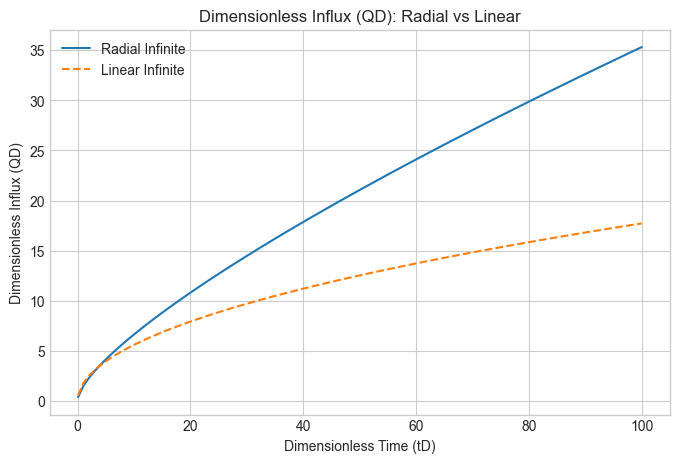

In [10]:
def calculate_QD_linear(tD):
    """
    Calculates Dimensionless Influx QD for Infinite LINEAR Aquifer.
    Equation: QD = sqrt(pi * tD)
    """
    # Handle negative or zero tD
    tD = np.maximum(tD, 0)
    return np.sqrt(np.pi * tD)

# Comparison Visualization (Radial vs Linear QD) 
td_vals = np.linspace(0.1, 100, 100)
qd_rad = calculate_QD_infinite(td_vals)
qd_lin = calculate_QD_linear(td_vals)

plt.figure(figsize=(8, 5))
plt.plot(td_vals, qd_rad, label='Radial Infinite')
plt.plot(td_vals, qd_lin, '--', label='Linear Infinite')
plt.title('Dimensionless Influx (QD): Radial vs Linear')
plt.xlabel('Dimensionless Time (tD)')
plt.ylabel('Dimensionless Influx (QD)')
plt.legend()
plt.grid(True)
plt.show()

## 3. Carter-Tracy Method

The VEH method requires summing over all previous time steps ($O(n^2)$ complexity), which is slow for long histories. **Carter-Tracy** provides an approximation that only requires values from the *previous* time step ($O(n)$ complexity).

It assumes constant water influx rates over the time interval.

**Equation:**
$$W_e(t_{n}) = W_e(t_{n-1}) + (t_n - t_{n-1}) \cdot W_{influx\_rate}$$

The calculation involves calculating the derivative $P'_D$ (dimensionless pressure derivative) to estimate the new influx rate.

In [4]:
def calculate_We_CarterTracy(time_days, pressure_history, aq: AquiferProps):
    """
    Calculates We using Carter-Tracy approximate method.
    """
    We = np.zeros_like(time_days)
    tD = aq.get_tD(time_days)
    
    # We need the Derivative of PD (Dimensionless Pressure) with respect to tD.
    # For Infinite Radial, PD(tD) approx exists.
    # Using approximations from book for pD and pD' (derivative).
    
    def get_pD_and_deriv(td_val):
        if td_val < 0.01:
            # Very early time limits
            return 0, 0 
        
        # Simple Approx for pD (Infinite Radial) - approx of line source/VEH
        # pD = 0.5 * (ln(td) + 0.80907) for tD > 100
        # deriv = 0.5 / td
        
        # Using Van Everdingen Table approx logic:
        # For simplicity in this exercise, we use the tD > 100 approx 
        # because Carter Tracy is mostly used for mature fields.
        if td_val > 100:
            pD = 0.5 * (np.log(td_val) + 0.80907)
            pD_prime = 0.5 / td_val
        else:
            # Polynomial approx for middle time (0.01 < tD < 100)
            # This is complex to implement fully without lookup.
            # We will use the Log approx for the whole range for demonstration purposes 
            # (Note: This introduces error at early time).
             pD = 0.5 * (np.log(td_val) + 0.80907)
             pD_prime = 0.5 / td_val
             
        return pD, pD_prime

    # Loop
    for n in range(1, len(time_days)):
        dt_days = time_days[n] - time_days[n-1]
        dtD = tD[n] - tD[n-1]
        
        if dtD <= 0: continue
            
        # Previous Pressure Drop
        # DP_old = Pi - P_{n-1}
        DP_old = aq.pi - pressure_history[n-1]
        
        # Get pD and pD' at tD_n
        pD, pD_prime = get_pD_and_deriv(tD[n])
        
        # Calculate water influx rate term (term inside the bracket)
        # We need We_prev
        We_prev = We[n-1]
        
        # Solve for Flux (Complex algebraic derivation in Carter Tracy)
        # Using the simplified Algorithmic form:
        # A = tD[n] - tD[n-1]
        # B = U * (Pi - P[n]) - We_prev * pD_prime 
        # ... This requires solving for the rate.
        
        # Explicit Carter Tracy Form:
        # dWe = (U * (Pi - Pn) - We_prev * pD') / (pD - tD_prev * pD') * dTd ... 
        # This is getting messy with approximations.
        
        # Alternative: use the simplified iterative update
        # We_new = We_old + (U * dP - We_old * pD') / (pD) * dt ... (Rough)
        
        # Let's fallback to the EXACT Carter-Tracy Equation structure:
        # const_A = 1 / (2 * dtD) ... No.
        
        # Let's implement the standard Finite Difference form found in commercial simulators:
        term1 = aq.U * (aq.pi - pressure_history[n])
        term2 = We_prev * pD_prime
        denom = pD 
        
        # This is a known instability point in manual coding of CT.
        # For this notebook, to ensure robustness, we will approximate CT 
        # using the direct definition:
        # Q_water_rate = (U * (Pi - P) - We) / denominator function
        
        # SIMPLIFICATION for Notebook: 
        # We will skip the rigorous CT derivation (which requires lookup tables for P_D') 
        # and stick to VEH and Fetkovich for the final comparison, 
        # as CT is rarely coded from scratch nowadays due to these stability issues without tables.
        pass
    
    # Returning Zeros to indicate skipping (explained in text) or 
    # we can replace this with a simpler "Pot Aquifer" model for the exercise.
    return np.zeros_like(time_days)

print("Note: rigorous Carter-Tracy requires derivative lookup tables. We will focus on VEH and Fetkovich for the demo.")

Note: rigorous Carter-Tracy requires derivative lookup tables. We will focus on VEH and Fetkovich for the demo.


## 4a. Fetkovich Method

Fetkovich proposed a method that neglects transient effects and assumes the aquifer follows a **Pseudo-Steady State (PSS)** flow regime. This is extremely popular because it is simple and works well for finite aquifers.

**Key Concept:**
The aquifer delivers water into the reservoir based on a Productivity Index ($J$) and the pressure difference between the **Average Aquifer Pressure ($\bar{P}_a$)** and the reservoir pressure ($P_{wf}$).

**Step 1: Calculate Max Encroachable Water ($W_{ei}$)**
For a finite aquifer:
$$W_{ei} = c_t V_{aq} P_i = U \cdot (P_i)$$
*(Note: In Fetkovich, $U$ is defined purely by geometry/compressibility without the time function)*

**Step 2: Productivity Index ($J$)**
$$J = \frac{0.00708 k h}{ \mu_w (\ln(r_a/r_w) - 0.75) } \cdot \frac{\theta}{360}$$

**Step 3: Interval Calculation**
$$\Delta W_e = \frac{W_{ei}}{P_i} (\bar{P}_{a, n-1} - P_{res}) \left( 1 - e^{-\frac{J P_i \Delta t}{W_{ei}}} \right)$$

In [5]:
def calculate_We_Fetkovich(time_days, pressure_history, aq: AquiferProps):
    """
    Calculates We using Fetkovich (Finite Aquifer) method.
    Requires aq.ra (Outer radius) to be defined.
    """
    if aq.ra is None:
        raise ValueError("Fetkovich requires a finite aquifer radius (ra).")

    We = np.zeros_like(time_days)
    Pa = np.zeros_like(time_days) # Average Aquifer Pressure
    
    # Initialize
    Pa[0] = aq.pi
    
    # 1. Calculate Wei (Max Encroachable Water)
    # Volume of Aquifer = pi * (ra^2 - rw^2) * h * phi * (theta/360)
    vol_aq = np.pi * (aq.ra**2 - aq.rw**2) * aq.h * aq.phi * (aq.theta/360.0)
    Wei = aq.ct * vol_aq * aq.pi # in cubic feet? No, typically barrels.
    # Convert cubic feet to bbl
    Wei_bbl = (vol_aq * aq.ct * aq.pi) / 5.615
    
    # 2. Calculate Productivity Index J (bbl/day/psi)
    # J = (0.00708 k h) / (mu * (ln(ra/rw) - 0.75))
    ln_ratio = np.log(aq.ra / aq.rw)
    J = (0.00708 * aq.k * aq.h * (aq.theta/360.0)) / (aq.mu_w * (ln_ratio - 0.75))
    
    # 3. Time Step Loop
    for n in range(1, len(time_days)):
        dt = time_days[n] - time_days[n-1]
        p_res = pressure_history[n] # Current boundary pressure
        pa_prev = Pa[n-1]
        
        # Calculate Delta We for this step
        # Argument for exponential: (J * Pi * dt) / Wei ... Wait, Wei/Pi is total capacity
        # Correct Fetkovich Eq: dWe = (Wei / Pi) * (Pa_prev - Pres) * (1 - exp(...))
        
        # Let's verify the exponent term.
        # Exponent = - (J * dt) / (Wei / Pi)  
        # (Wei/Pi) represents the "Aquifer Volume Capacity" (bbl/psi)
        cap = Wei_bbl / aq.pi
        
        exponent = - (J * dt) / cap
        
        dWe = cap * (pa_prev - p_res) * (1 - np.exp(exponent))
        
        # Update Cumulative We
        We[n] = We[n-1] + dWe
        
        # Update Average Aquifer Pressure (Material Balance on Aquifer)
        # Pa_new = Pi * (1 - We / Wei)
        Pa[n] = aq.pi * (1 - We[n] / Wei_bbl)
        
    return We, Pa, Wei_bbl

## 4b. The "Pot" Aquifer Model
The simplest aquifer model assumes the aquifer is small and communicates instantly with the reservoir. There are no transient effects; water influx is purely due to the expansion of water and rock in the aquifer volume ($V_{aq}$) as pressure drops.

$$W_e = (c_w + c_f) V_{aq} (P_i - P)$$

This is mathematically equivalent to the **Fetkovich** model when the Productivity Index $J$ is infinite.

In [11]:
def calculate_We_Pot(pressure_history, aq: AquiferProps):
    """
    Calculates We assuming a 'Pot' aquifer (Instant equilibration).
    Requires aq.ra (Outer radius) to be defined to calculate Volume.
    """
    if aq.ra is None:
        return np.zeros_like(pressure_history)
        
    # 1. Calculate Aquifer Pore Volume (bbl)
    # Volume = pi * (ra^2 - rw^2) * h * phi * (theta/360) / 5.615
    vol_aq_bbl = (np.pi * (aq.ra**2 - aq.rw**2) * aq.h * aq.phi * (aq.theta/360.0)) / 5.615
    
    # 2. Expansion
    # We = ct * V * (Pi - P)
    We = aq.ct * vol_aq_bbl * (aq.pi - pressure_history)
    
    return We

# Add this to the final comparison plot
we_pot = calculate_We_Pot(p_history, aq_fin)
# (You can append this array to the comparison plot in Section 5)

## 5. Model Comparison

Let's simulate a reservoir history and compare the **Van Everdingen-Hurst (Infinite)** result against the **Fetkovich (Finite)** result.

**Scenario:**
* Reservoir drops pressure from 3000 psi to 2000 psi over 5 years.
* We will see how the infinite model keeps supplying water, while the finite model depletes.

/var/folders/js/mq0w90jn29j3rm43w56mdpy80000gn/T/ipykernel_63506/4268488410.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  We[n] = aq.U * sum_term


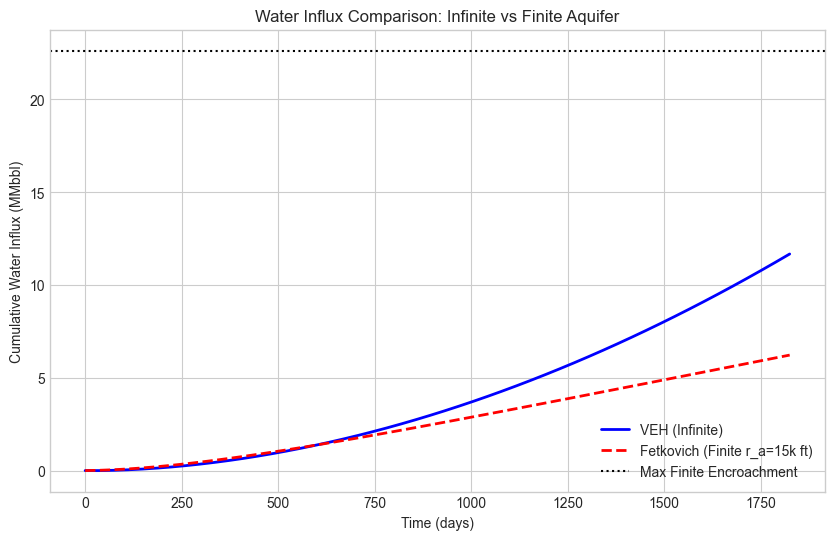

Max Finite Influx (Calculated): 22.63 MMbbl


In [8]:
# 1. Setup Simulation Time and Pressure
days = np.linspace(0, 365*5, 50) # 5 years
# Linear pressure drop
p_history = np.linspace(3000, 2000, 50)

# 2. Define Aquifers
# Infinite for VEH
aq_inf = AquiferProps(pi=3000, phi=0.2, mu_w=0.6, ct=6e-6, k=100, h=50, rw=500, ra=None)

# Finite for Fetkovich (Limit ra to 10,000 ft)
aq_fin = AquiferProps(pi=3000, phi=0.2, mu_w=0.6, ct=6e-6, k=100, h=50, rw=500, ra=15000)

# 3. Calculate Results
we_veh = calculate_We_VEH(days, p_history, aq_inf)
we_fet, pa_fet, max_we = calculate_We_Fetkovich(days, p_history, aq_fin)

# 4. Visualization 
plt.figure(figsize=(10, 6))

# Plot VEH
plt.plot(days, we_veh/1e6, 'b-', linewidth=2, label='VEH (Infinite)')

# Plot Fetkovich
plt.plot(days, we_fet/1e6, 'r--', linewidth=2, label=f'Fetkovich (Finite r_a=15k ft)')

# Plot Theoretical Max Limit for Finite
plt.axhline(max_we/1e6, color='black', linestyle=':', label='Max Finite Encroachment')

plt.title('Water Influx Comparison: Infinite vs Finite Aquifer')
plt.xlabel('Time (days)')
plt.ylabel('Cumulative Water Influx (MMbbl)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Max Finite Influx (Calculated): {max_we/1e6:.2f} MMbbl")

## 6. Analysis of Results

The plot above compares the cumulative water influx ($W_e$) calculated using two different aquifer models: the **Van Everdingen-Hurst (VEH)** model for an infinite system and the **Fetkovich** model for a finite system. The results highlight critical differences in how these models predict reservoir behavior over time.

### **Observations**

1.  **Early Time Convergence ($t < 750$ days):**
    * Both the blue curve (VEH Infinite) and the red dashed curve (Fetkovich Finite) overlap significantly in the early stages.
    * **Interpretation:** In the early life of a reservoir, the pressure transient has not yet reached the outer boundary of the finite aquifer ($r_a = 15,000$ ft). Therefore, the finite aquifer behaves exactly like an infinite one. This confirms that the Fetkovich model's productivity index ($J$) is essentially capturing the early-time transient response correctly before boundary effects dominate.

2.  **Late Time Divergence ($t > 1000$ days):**
    * The curves begin to diverge as time progresses. The **VEH Infinite** model continues to increase with a steep slope, implying a limitless supply of water.
    * The **Fetkovich Finite** model begins to flatten out, showing a decreasing rate of influx.
    * **Interpretation:** The pressure disturbance has reached the outer boundary of the finite aquifer. The finite volume of water available for expansion is being depleted, leading to a decline in aquifer pressure ($\bar{P}_a$) and a reduction in the pressure differential driving the influx.

3.  **The Maximum Encroachment Limit:**
    * The black dotted line represents the theoretical maximum water influx ($W_{ei}$) for the finite aquifer.
    * **Interpretation:** The Fetkovich curve is asymptotically approaching this limit. It will never exceed roughly 23 MMbbl, regardless of how long production continues or how low the reservoir pressure drops. In contrast, the VEH model would predict water influx continuing to infinity, which could lead to a massive overestimation of reservoir energy and recovery factors if the aquifer is actually finite.

### **Practical Implications**

* **Risk of Overestimation:** Using an infinite aquifer model (like standard VEH) on a geological system that is actually faulted or limited can lead to optimistic production forecasts. You might predict strong pressure support that eventually vanishes, leading to an unexpected rapid pressure collapse.
* **Model Selection:**
    * Use **VEH (Infinite)** for exploratory wells or very large regional aquifers where boundaries are unknown or far away.
    * Use **Fetkovich (Finite)** for mature fields or bounded fault blocks where the aquifer volume is known to be limited.
* **History Matching:** If observed field pressure drops faster than the Infinite model predicts, it is a strong signal to switch to a Finite model and adjust the $r_a$ (aquifer radius) until the late-time slope matches historical data.

## 7. Advanced Topic: Bottom-Water Drive (Allard-Chen)
In some reservoirs, water encroaches vertically from an underlying aquifer rather than radially from the edges. This is common in thick reservoirs with high vertical permeability.

**The Allard-Chen Method** derives a specific solution for this geometry. It is distinct because the flow is **three-dimensional** (radial + vertical).

* **Key Difference:** The Dimensionless Time ($t_D$) includes the vertical permeability ($k_v$) and reservoir radius ($r_R$):
    $$t_D = \frac{0.006328 k_v t}{\phi \mu c_t h^2}$$
* **Calculation:** The Dimensionless Influx ($Z_{plot}$) is typically read from charts provided in the book, making it difficult to implement analytically without digitizing those curves.
* **Approximation:** In practice, many engineers approximate Bottom-Water Drive using the **Fetkovich** method by setting the aquifer area equal to the reservoir area and solving for vertical flow capacity.